In [34]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date

import file


In [35]:
# Define the ticker symbol
tickerSymbol = 'FNGS'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2022-1-1', end=date.today())

In [36]:
gap = 0
option_prices = {
    # 1: [44/0.5], # -1500%
    2: [59/0.77],
    4: [49/1.07],
    5: [53/1.5],
    6: [44/1.42],
    7: [59/1.92],
    8: [49/1.95],
    9: [53/2.12],
    11: [59/2.6],
    17: [49/3.28],
    18: [53/3.1],
    19: [44/2.9],
    21: [49/3.37],
    24: [59/4.65],
    30: [49/4.45],
    31: [53/4.8],
    32: [44/4.15],
    36: [44/4.53],
    54: [59/7.25],
    61: [53/7.45]
}
print('option leverages:')
for w in option_prices:
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}

# normalize values so longer expirations have lower leverage
option_leverage = {k: v for k, v in zip(sorted(option_leverage.keys()), sorted(option_leverage.values(), reverse=True))}

print('mean option leverage, break even:')
for w in option_leverage:
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
	 2w 76.6
	 4w 45.8
	 5w 35.3
	 6w 31.0
	 7w 30.7
	 8w 25.1
	 9w 25.0
	11w 22.7
	17w 14.9
	18w 17.1
	19w 15.2
	21w 14.5
	24w 12.7
	30w 11.0
	31w 11.0
	32w 10.6
	36w  9.7
	54w  8.1
	61w  7.1
mean option leverage, break even:
	 2w 76.6  1.3%
	 4w 45.8  2.2%
	 5w 35.3  2.8%
	 6w 31.0  3.2%
	 7w 30.7  3.3%
	 8w 25.1  4.0%
	 9w 25.0  4.0%
	11w 22.7  4.4%
	17w 17.1  5.8%
	18w 15.2  6.6%
	19w 14.9  6.7%
	21w 14.5  6.9%
	24w 12.7  7.9%
	30w 11.0  9.1%
	31w 11.0  9.1%
	32w 10.6  9.4%
	36w  9.7 10.3%
	54w  8.1 12.3%
	61w  7.1 14.1%
option gap: 0.00%


In [37]:
max_weeks = 50

stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.mean() * 52 / weeks) # annualized

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = stock_changes[weeks:].apply(lambda x: max(-100, (x - gap) * lvr - 100))
        mean_profit = option_profits.mean() * 52 / weeks # annualized
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append([weeks, mean_profit, positive_percent])
        history[f'Option {weeks}w'] = option_profits # ? * 52 / weeks # annualized

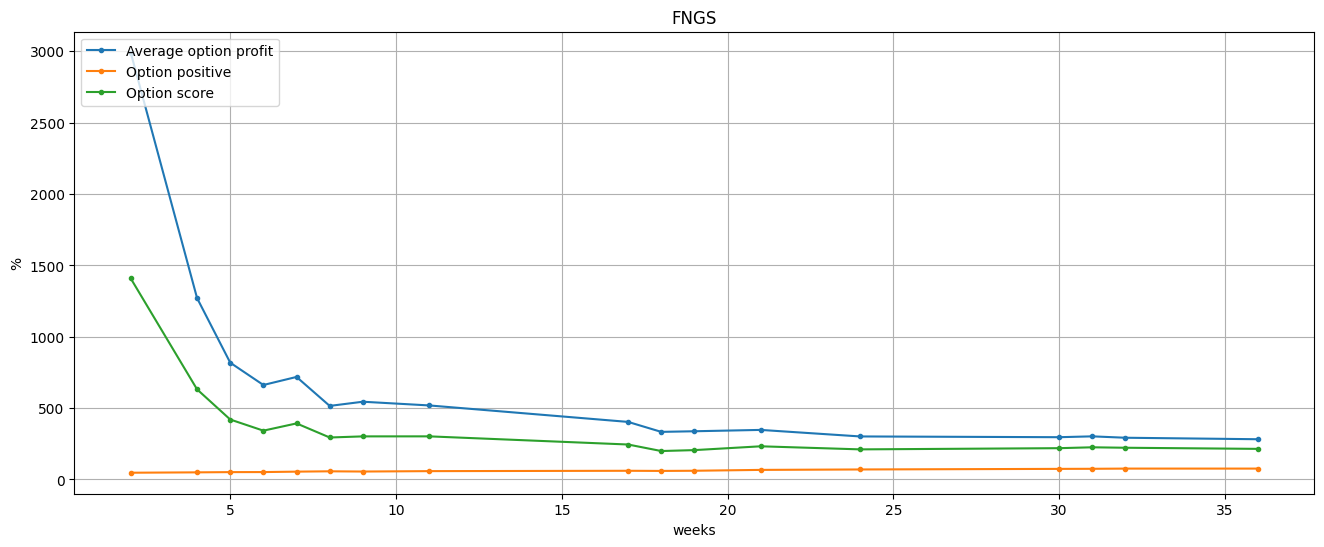

In [38]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
plt.plot(option_weeks, option_score, label='Option score', marker='.')
# plt.axhline(y=0, color='k', linestyle='--')
plt.legend(loc='upper left')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

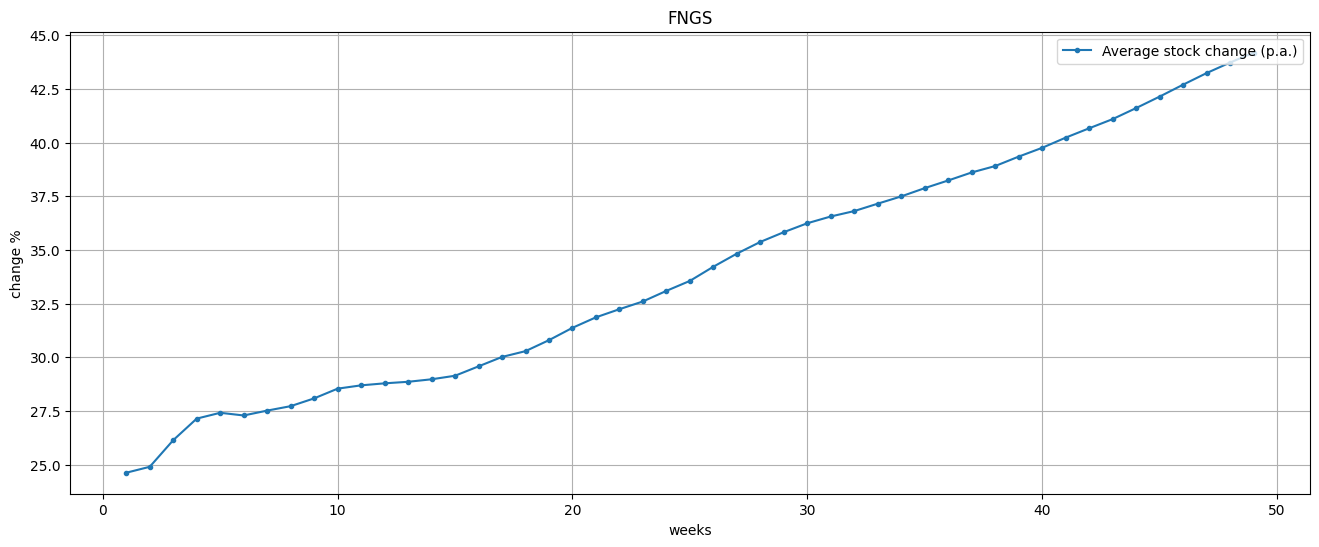

In [39]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Average stock change (p.a.)', marker='.')
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()
